Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = ""
COLLABORATORS = ""

---

# Perceptron

![](https://upload.wikimedia.org/wikipedia/commons/thumb/8/8a/Perceptron_example.svg/500px-Perceptron_example.svg.png)

## Optimization for classification

$$ y = mx + c $$

$$ e(y_i, x_i; m,c) = \begin{cases}
0 &\text{ if } m x_i + c  = l_i\\
|m x_i + c| &\text{ if }  m x_i + c  \ne l_i
\end{cases}$$
$\newcommand{\bfm}{\mathbf{m}}$
$$ e(y_i, x_i; m, c) = \begin{cases}
0 &\text{ if } m x_i + c  = l_i\\
|m x_i + c| &\text{ if }  m x_i + c  \ne l_i
\end{cases}$$

$$\bfm = \begin{bmatrix}m \\ c\end{bmatrix}$$

$$ e(y_i, x_i;\bfm) = \begin{cases}
0 &\text{ if } \begin{bmatrix} x_i& 1\end{bmatrix}\bfm  = l_i\\
|\begin{bmatrix} x_i& 1\end{bmatrix}\bfm| &\text{ if }  \begin{bmatrix} x_i& 1\end{bmatrix}\bfm  \ne l_i
\end{cases}$$

$$ \nabla_\bfm e(y_i, x_i;\bfm) = \begin{cases}
0 &\text{ if } \begin{bmatrix} x_i& 1\end{bmatrix}\bfm  = l_i\\
|\begin{bmatrix} x_i& 1\end{bmatrix}| &\text{ if }  \begin{bmatrix} x_i& 1\end{bmatrix}\bfm  \ne l_i
\end{cases}$$

If $l_i \in \{-1, 1\}$, then we can write

$$ e(y_i, x_i;\bfm) =  \max\{0, - l_i \begin{bmatrix} x_i& 1\end{bmatrix}\bfm\} $$
$$ \nabla_\bfm e(y_i, x_i;\bfm) = \max\{0, - l_i \begin{bmatrix} x_i& 1\end{bmatrix}\} $$

In [2]:
# Download MNIST dataset
!F=train-images-idx3-ubyte && cd data && \
    [ ! -f $F ] && \
    wget http://yann.lecun.com/exdb/mnist/$F.gz  && \
    gunzip $F.gz
!F=train-labels-idx1-ubyte && cd data && \
    [ ! -f $F ] && \
    wget http://yann.lecun.com/exdb/mnist/$F.gz  && \
    gunzip $F.gz

In [3]:
# Load MNIST dataset from uint8 byte files
import struct
import numpy as np

# Ref:https://github.com/sorki/python-mnist/blob/master/mnist/loader.py
def mnist_read_labels(fname='data/train-labels-idx1-ubyte'):
    with open(fname, 'rb') as file:
        # The file starts with 4 byte 2 unsigned ints 
        magic, size = struct.unpack('>II', file.read(8))
        assert magic == 2049
        labels = np.frombuffer(file.read(), dtype='u1')
        return labels
    
# Ref:https://github.com/sorki/python-mnist/blob/master/mnist/loader.py
def mnist_read_images(fname='data/train-images-idx3-ubyte'):
    with open(fname, 'rb') as file:
        # The file starts with 4 byte 4 unsigned ints 
        magic, size, rows, cols = struct.unpack('>IIII', file.read(16))
        assert magic == 2051
        image_data = np.frombuffer(file.read(), dtype='u1')
        images = image_data.reshape(size, rows, cols)
        return images

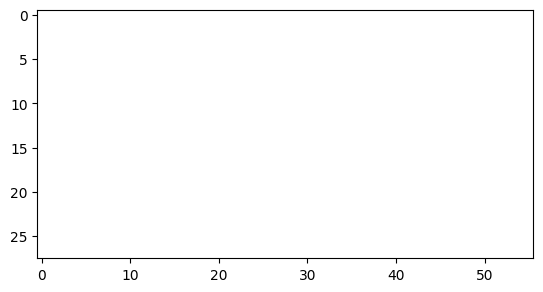

In [4]:
# Visualize the dataset
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl
mpl.rc('animation', html='jshtml')
train_images = mnist_read_images('data/train-images-idx3-ubyte')
labels = mnist_read_labels('data/train-labels-idx1-ubyte')
zero_images = train_images[labels==0, ...] # Filter by label == 0
one_images = train_images[labels==1, ...] # Filter by label == 1

# fig, axes = plt.subplots(2, 10)
# for axrow, imgs in zip(axes, (zero_images, one_images)):
#     for ax, img in zip(axrow, imgs):    
#         ax.imshow(img, cmap='gray', vmin=0, vmax=255)
#         ax.axis('off')

        
fig, ax = plt.subplots()
# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame

ims = [[ax.imshow(np.hstack((zero_images[i], one_images[i])), animated=True, cmap='gray', vmin=0, vmax=255)]
    for i in range(60)]
zero_images_anim = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000, repeat=False)

## Images as arrays


In [5]:
train_images.shape

(60000, 28, 28)

In [6]:
img1 = train_images[0]
img1

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

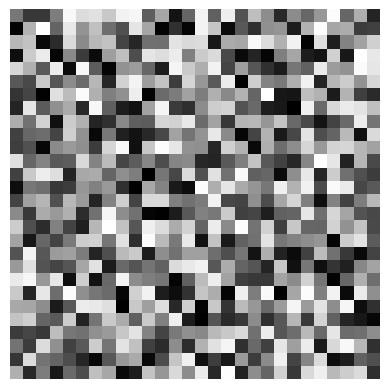

In [20]:
## Visualizing matrices
fig, ax = plt.subplots()
ax.axis('off')
ax.imshow([[1, 0],
           [0, 1]], cmap='gray')
ax.imshow(np.random.rand(28, 28), cmap='gray')

In [8]:
zero_images_anim

# What is a feature

Any property of data sample that helps with the task.

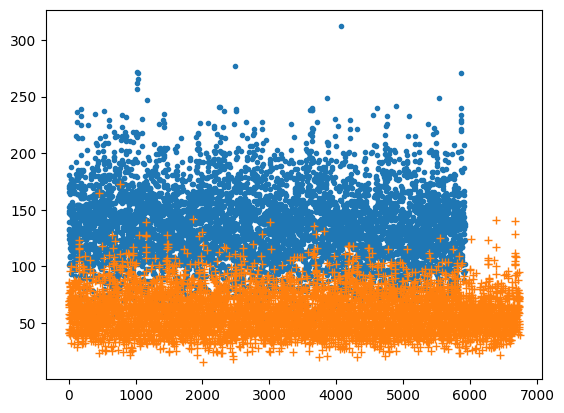

In [9]:
def feature_n_pxls(imgs):
    n, *shape = imgs.shape
    return np.sum(imgs[:, :, :].reshape(n, -1) > 128, axis=1)

n_pxls_zero_images = feature_n_pxls(zero_images)
n_pxls_one_images = feature_n_pxls(one_images)
fig, ax = plt.subplots()
ax.plot(n_pxls_zero_images, '.')
ax.plot(n_pxls_one_images, '+')

Text(0, 0.5, 'Averge intensity')

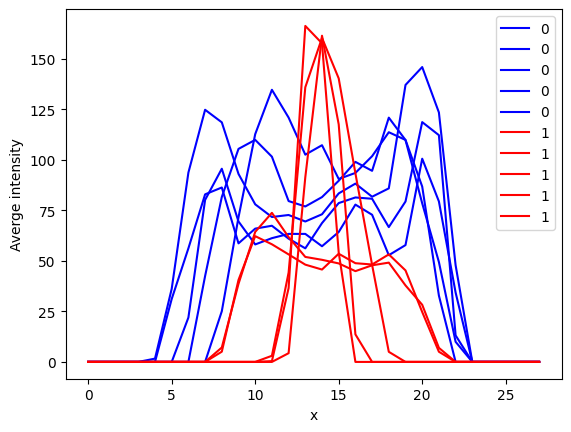

In [10]:
fig, ax = plt.subplots()
for i in range(5):
    ax.plot(zero_images[i].mean(axis=0), 'b-', label='0')
for i in range(5):
    ax.plot(one_images[i].mean(axis=0), 'r-', label='1')
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('Averge intensity')

$$ \mu_x(I) = \sum_{x = 1}^{W} \frac{x I(x, y)}{\sum_{x=1}^{W} I(x, y)} $$
$$ \sigma^2_x(I) = \sum_{x=1}^W \frac{(x - \mu_x)^2I(x, y)}{\sum_{x=1}^{W} I(x, y)}  $$

In [11]:
wts = zero_images[0].mean(axis=0)
mean = (np.arange(wts.shape[0]) * wts).sum() / np.sum(wts)
var = ((np.arange(wts.shape[0]) - mean)**2 * wts).sum() / np.sum(wts)
var

22.811061800377757

In [12]:
def feature_y_var(img):
    wts = img.mean(axis=0)
    mean = (np.arange(wts.shape[0]) * wts).sum() / np.sum(wts)
    var = ((np.arange(wts.shape[0]) - mean)**2 * wts).sum() / np.sum(wts)
    return var
feature_y_var(zero_images[0]), feature_y_var(one_images[0])


(22.811061800377757, 11.384958735403274)

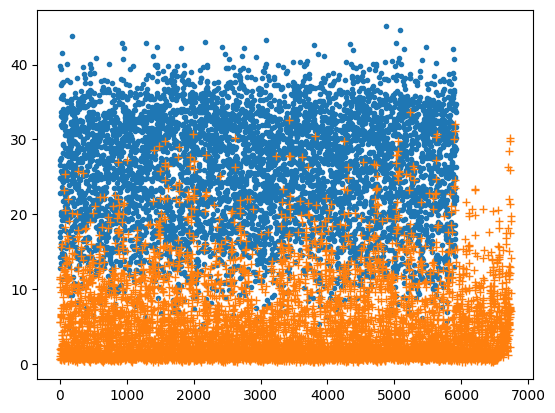

In [13]:
def feature_y_var(imgs):
    wts = imgs.mean(axis=-2)
    arange = np.arange(wts.shape[-1])
    mean = (arange * wts).sum(axis=-1) / wts.sum(axis=-1)
    mean = mean[:, np.newaxis]
    var = ((arange - mean)**2 * wts).sum(axis=-1) / wts.sum(axis=-1)
    return var

fig, ax = plt.subplots()
ax.plot(feature_y_var(zero_images), '.')
ax.plot(feature_y_var(one_images), '+')

In [14]:
def features_extract(images):
    return np.vstack((feature_n_pxls(images),
                      feature_y_var(images))).T
zero_features = features_extract(zero_images)
one_features = features_extract(one_images)


def draw_features(ax, zero_features, one_features):
    zf = ax.scatter(zero_features[:, 0], zero_features[:, 1], marker='.', label='0', alpha=0.5)
    of = ax.scatter(one_features[:, 0], one_features[:, 1], marker='+', label='1', alpha=0.3)
    ax.legend()
    ax.set_xlabel('Feature 1: count of pixels')
    ax.set_ylabel('Feature 2: Variance along x-axis')
    return [zf, of] # return list of artists

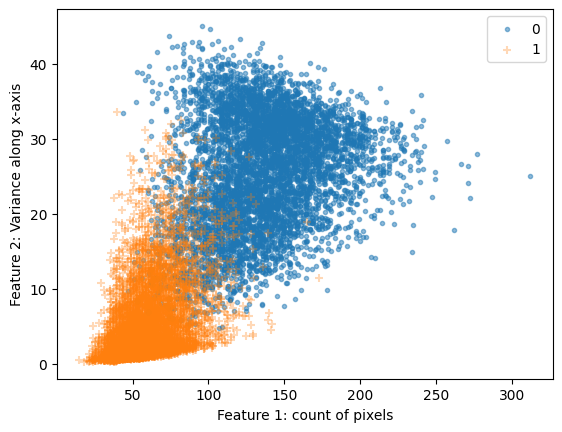

In [15]:
fig, ax = plt.subplots()
draw_features(ax, zero_features, one_features)
plt.show()

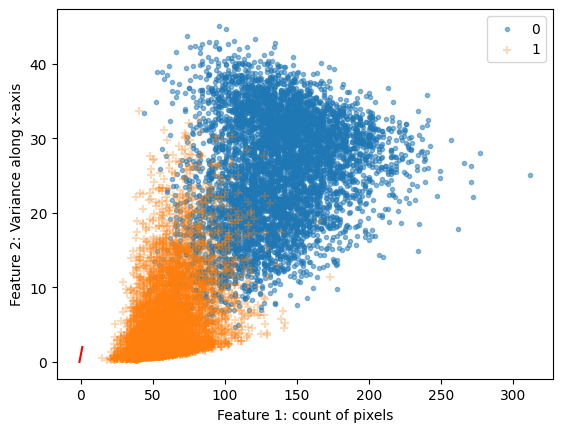

In [16]:
bfm = np.ones(2)
fig, ax = plt.subplots()
draw_features(ax, zero_features, one_features)
x = np.linspace(-1, 1, 21)
ax.plot(x, x*bfm[0] + bfm[1], 'r-')

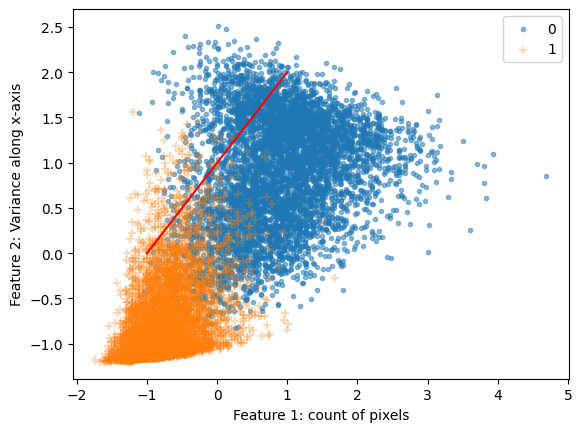

In [17]:
bfm = np.ones(2)

Y = np.hstack((np.ones(zero_features.shape[0]), np.full(one_features.shape[0], -1.0)))
features = np.vstack((zero_features, one_features))
FEATURES_MEAN = features.mean(axis=0, keepdims=1)
FEATURES_STD = features.std(axis=0, keepdims=1)
np.savez('features_stats.npz', mean=FEATURES_MEAN, std=FEATURES_STD)

def norm_features(features):
    return (features - FEATURES_MEAN) / FEATURES_STD
    
X = norm_features(features)

fig, ax = plt.subplots()
draw_features(ax, X[Y > 0, :], X[Y < 0, :])
x = np.linspace(-1, 1, 21)
ax.plot(x, x*bfm[0] + bfm[1], 'r-')

In [18]:


def error(X, Y, bfm):
    # YOUR CODE HERE
    raise NotImplementedError()

def grad_error(Xw, Yw, bfm):
    # YOUR CODE HERE
    raise NotImplementedError()

def train(X, Y, lr = 0.1):
    # YOUR CODE HERE
    raise NotImplementedError()

OPTIMAL_BFM, list_of_bfms, list_of_errors = train(X, Y)
fig, ax = plt.subplots()
ax.plot(list_of_errors)
ax.set_xlabel('t')
ax.set_ylabel('loss')
plt.show()

NotImplementedError: 

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(5, 7.5))
class Anim:
    def __init__(self, fig, axes, X, Y):
        self.fig = fig
        self.ax = axes[0]
        self.ax1 = axes[1]
        self.fts = draw_features(self.ax, X[Y > 0, :], X[Y < 0, :])
        self.line, = self.ax.plot([], [], 'r-')
        
        m, c = np.meshgrid(np.linspace(-1, 1, 51), np.linspace(-1, 1, 51))
        totalerr = np.empty_like(m)
        for i in range(m.shape[0]):
            for j in range(m.shape[1]):
                err = error(X, Y, [m[i, j], c[i,j]])
                totalerr[i, j] = err[err > 0].mean()

        self.ctr = self.ax1.contour(m, c, totalerr, 30, cmap='Blues_r')
        self.ax1.set_xlabel('m')
        self.ax1.set_ylabel('c')
        self.ax1.clabel(self.ctr, self.ctr.levels, inline=True, fontsize=6)
        self.m_hist = []
        self.c_hist = []
        self.line2, = self.ax1.plot([], [], 'r*-')

        
    def anim_init(self):
        return (self.line, self.line2)
        
    def update(self, bfm):
        x = np.linspace(-2, 2, 21)
        self.line.set_data(x, x * bfm[0] + bfm[1])
        self.m_hist.append(bfm[0])
        self.c_hist.append(bfm[1])
        self.line2.set_data(self.m_hist, self.c_hist)
        return self.line, self.line2

fig, axes = plt.subplots(2, 1, figsize=(5, 7.5))    
a = Anim(fig, axes, X, Y)
animation.FuncAnimation(fig, a.update, frames=list_of_bfms[::3],
                        init_func=a.anim_init, blit=True, repeat=False)

In [ ]:
test_images = mnist_read_images('data/t10k-images-idx3-ubyte')
test_labels = mnist_read_labels('data/t10k-labels-idx1-ubyte')
zero_one_filter = (test_labels == 0) | (test_labels == 1)
zero_one_test_images = test_images[zero_one_filter, ...]
zero_one_test_labels = test_labels[zero_one_filter, ...]

def returnclasslabel(test_imgs):
    Xtest = norm_features(features_extract(test_imgs))
    bfm = OPTIMAL_BFM
    return np.where(
        Xtest[:, 1] - Xtest[:, 0] * bfm[0] - bfm[1] > 0, 
        0,
        1)
zero_one_predicted_labels = returnclasslabel(zero_one_test_images)

In [ ]:
accuracy = np.sum(zero_one_test_labels == zero_one_predicted_labels) / len(zero_one_test_labels)
accuracy

In [ ]:
positive_label = 1
negative_label = 0
TP = np.sum((zero_one_test_labels == positive_label) & (zero_one_predicted_labels == positive_label))
TP

In [ ]:
TN =  np.sum((zero_one_test_labels == negative_label) & (zero_one_predicted_labels == negative_label))
TN

In [ ]:
FP = np.sum((zero_one_test_labels != positive_label) & (zero_one_predicted_labels == positive_label))
FP

In [ ]:
FN = np.sum((zero_one_test_labels != negative_label) & (zero_one_predicted_labels == negative_label))
FN

In [ ]:
# Confusion matrix
fig, ax = plt.subplots()
ax.imshow([[TN, FN],
          [FP, TP]])
ax.set_xlabel('predicted')
ax.set_ylabel('true')
ax.axis('off')

In [ ]:

fig, ax = plt.subplots()
artists = []
for i in range(60):
    artists.append(
        [ax.imshow(zero_one_test_images[i], animated=True, cmap='gray', vmin=0, vmax=255),
        ax.text(0, 2, 'The number is %d' % zero_one_predicted_labels[i], animated=True, color='w')])
animation.ArtistAnimation(fig, artists, interval=50, blit=True,
                                repeat_delay=1000, repeat=False)

# Single Layer Neural Networks

[Read Chapter 2 and 3 of UDL Book](https://github.com/udlbook/udlbook/blob/main/Understanding_Deep_Learning_01_10_22_C.pdf)



*Notes* Single Layer Neural Networks are simplest kind of neural networks. But before we dive into single layer neural networks, may be we should focus on the name _neural_ networks. The name neural networks comes from biological neurons.

## Similarities between Artificial neuron and Biological neuron



<img src="imgs/neuron.png" style="width:400px" />

<img src="imgs/nn-overlayed-neuron.svg" style="width:400px" />

1. The excitation or firing of a biological neuron can be equated to a high positive value of units ($x_1, x_2, x_3$) in artificial neurons.

2. The synapse in biological neuron determines which input excitations will have excitatory or inhibitary impact on output excitations. Synapses can strengthen, weaken, disconnect or form new connections during biological learning. Similarly to excitatory synapes, positive weights can cause positive input values to contribute to positive output values.

3. Usually multiple excitatory inputs are required excite the output neuron.

References: 
1. https://openstax.org/books/biology/pages/35-2-how-neurons-communicate

## Differences

1. Biological neuron is all or None
2. Biological neuron has a time component
<img src="imgs/synapse-time-component.png" style="width:400px" />



*notes*
1. The activity of the biological neuron is an "all-or-none" process. Articial activations are typically continuous range. Even when sigmoid or softmax nonlinearities.

2. Biological neuron has time dynamics. The input activations are integrated over time.

## Next

2. Show visualization of 1D optimization and loss functions.

3. Build to visualizations in the UDL book. Connect to KD tree and nearest neighbor classification.

4. Show the tensflow js visualization.




## References
1. http://playground.tensorflow.org
2. https://knowyourdata-tfds.withgoogle.com/#tab=STATS&dataset=tf_flowers
3. "Flowers", The TensorFlow Team. Jan 2019. Online http://download.tensorflow.org/example_images/flower_photos.tgz